In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Your path here (df must be with week_index so 
# at first run feature_engineering notebook)
# path = '/content/drive/MyDrive/Прогноз металлические заготовки/'
# path = '/content/drive/MyDrive/'
file_name = 'shifted_data.csv'
df = pd.read_csv(path + file_name)

df.shape

(268, 221)

In [ ]:
df.drop(['timepoint'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Columns: 220 entries, target to 8-shifted Purchase Price Index
dtypes: float64(220)
memory usage: 460.8 KB


In [ ]:
sel_features = ['mean_w_product1, CFR market1',
                'mean_w_product1 country1, EXW',
                'target', 
                'min_w_product1 country1, EXW', 
                'max_w_product1, CFR market1', 
                '1-shifted max_w_product1 country1, EXW', 
                'max_w_product1 country1, EXW', 
                '8-shifted Price.1', 
                '2-shifted Price.2', 
                'mean_w_Fe 62%, CFR country1', 
                'Scrap, CIF SEA', 
                '1-shifted USD/CUR1 (Price)', 
                'Price.2', 
                'country3 Industrial Production', 
                '1-shifted Price.2', 
                '1-shifted sum_w_Fe 62%, CFR country1', 
                '2-shifted Purchasing Managers Index - Manufacturing', 
                '1-shifted Scrap, CIF SEA', 
                '2-shifted USD/CUR1 (Price)', 
                '4-shifted USD/CUR5 (Price)', 
                '1-shifted Purchasing Managers Index - Manufacturing', 
                '4-shifted USD/CUR2 (Price)', 
                '2-shifted country3 Industrial Production', 
                'USD/CUR1 (Price)', 
                '8-shifted Purchase Price Index', 
                'PMI', 
                'min_w_Fe 62%, CFR country1', 
                'HCC, FOB Aust.1', 
                '8-shifted housing starts', 
                '4-shifted Actual', 
                '4-shifted housing starts, country1', 
                'Total Exports', 
                'mean_w_HCC, FOB Aust', 
                'country4 Business Confidence', 
                '8-shifted Price', 
                '2-shifted country4 Business Confidence']

In [ ]:
df = df.loc[:, sel_features]

In [ ]:
df.head()

,"mean_w_product1, CFR market1","mean_w_product1 country1, EXW",target,"min_w_product1 country1, EXW","max_w_product1, CFR market1","1-shifted max_w_product1 country1, EXW","max_w_product1 country1, EXW",8-shifted Price.1,2-shifted Price.2,"mean_w_Fe 62%, CFR country1","Scrap, CIF SEA",1-shifted USD/CUR1 (Price),Price.2,country3 Industrial Production,1-shifted Price.2,"1-shifted sum_w_Fe 62%, CFR country1",2-shifted Purchasing Managers Index - Manufacturing,"1-shifted Scrap, CIF SEA",2-shifted USD/CUR1 (Price),4-shifted USD/CUR5 (Price),1-shifted Purchasing Managers Index - Manufacturing,4-shifted USD/CUR2 (Price),2-shifted country3 Industrial Production,USD/CUR1 (Price),8-shifted Purchase Price Index,PMI,"min_w_Fe 62%, CFR country1","HCC, FOB Aust.1",8-shifted housing starts,4-shifted Actual,"4-shifted housing starts, country1",Total Exports,"mean_w_HCC, FOB Aust",country4 Business Confidence,8-shifted Price,2-shifted country4 Business Confidence
0,553.0,501.214824,548.0,500.70416,553.0,501.56348,501.56348,7572.420,13807.340000,120.492,358.0,46.1478,13807.34,17.460000,13807.34,602.46,130.200000,358.0,46.147800,266.800,130.200000,128.570000,17.460000,46.1478,207.200000,129.000000,116.44,183.0,15620.210000,47.600000,1.207120e+06,49.219338,184.356,129.400000,13563.260000,129.400000
1,553.0,501.602904,548.0,501.52344,553.0,501.65126,501.73904,7572.420,13807.340000,124.140,358.0,46.1478,13807.34,22.114913,13807.34,487.44,131.282385,358.0,46.147800,263.120,131.282385,128.340000,19.787456,46.1478,207.320289,130.425776,123.50,183.0,16482.122507,42.849444,1.209252e+06,51.128966,183.540,132.748470,13452.580000,131.074235
2,553.0,521.077224,548.0,501.51420,553.0,517.48813,533.23722,7657.880,13953.006667,125.072,358.0,46.0963,14244.34,24.638907,14025.84,498.89,132.162010,358.0,46.113467,261.460,133.143015,128.343333,21.404606,46.0448,207.610168,131.407998,120.30,183.0,17494.470559,39.476226,1.211664e+06,52.339521,185.676,134.883200,13507.426667,132.343890
3,563.0,549.152528,573.0,535.99784,563.0,546.66733,560.09744,7732.210,14159.126667,134.212,358.0,46.0628,14425.70,25.497444,14335.02,648.21,133.747132,358.0,46.091133,261.345,134.438314,128.255000,24.083754,46.0808,208.047371,132.017332,130.04,185.0,18645.479621,37.284982,1.214335e+06,52.969013,188.704,136.003695,13524.470000,134.545122
4,583.0,559.508940,583.0,545.63856,583.0,566.59939,573.10134,7825.652,14524.086667,134.220,358.0,46.0484,14902.22,25.155987,14663.96,671.08,134.809870,358.0,46.047200,261.180,135.254174,127.902000,25.097446,46.0160,208.609636,132.324443,129.58,187.0,19923.375157,36.080347,1.217242e+06,53.135456,190.764,136.309460,13585.804000,135.732119


In [ ]:
import joblib

scaler_filename = path + "scaler.save"

def scale(X):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))

    X_train = scaler.fit_transform(X[0])
    X_valid = scaler.transform(X[1])

    joblib.dump(scaler, scaler_filename) 
    X_train = pd.DataFrame(X_train, columns=sel_features)
    X_valid = pd.DataFrame(X_valid, columns=sel_features)

    return X_train, X_valid

In [ ]:
def split_scale(train, valid, num_of_weeks):
    targets = ['target_in_'+str(week)+'_weeks' for week in range(1, num_of_weeks+1)]

    X_train = train.drop(targets, axis=1)
    X_valid = valid.drop(targets, axis=1)
    y_train = train[targets]
    y_valid = valid[targets]

    X_train, X_valid = scale([X_train, X_valid])

    data = {'X_train': X_train,
            'X_valid': X_valid,
            'y_train': y_train,
            'y_valid': y_valid}

    return data

In [ ]:
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

def nn_model_train(data, num_weeks):
    X_train, X_valid, y_train, y_valid = data.values()
    inp_size = X_train.shape[1]

    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(inp_size,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_weeks))

    model_name = 'my_best_model.hdf5'

    model_checkpoint_callback = ModelCheckpoint(filepath=path+model_name,
                                                save_weights_only=False,
                                                monitor='val_mae',
                                                mode='min',
                                                save_best_only=True)

    model_early_stop_callback = EarlyStopping(monitor="val_loss",
                                              patience=200,
                                              verbose=1,
                                              mode="min")
    
    model.compile(optimizer='rmsprop', 
                  loss='mse', 
                  metrics=['mae'])
    
    history = model.fit(X_train, y_train,
                        steps_per_epoch=1,
                        epochs=5000,
                        callbacks=[model_early_stop_callback,
                                   model_checkpoint_callback],
                        validation_data=(X_valid, y_valid),
                        validation_steps=1)
    
    y_train_pred = model.predict(X_train, steps=1)
    y_pred = model.predict(X_valid, steps=1)

    score_train = mse(y_train, y_train_pred) ** 0.5
    score_valid = mse(y_valid, y_pred) ** 0.5
    # score_train = None
    # score_valid = None
    
    return history, (score_train, score_valid), y_pred

In [ ]:
def xgb_train(data, num_weeks):
    X_train, X_valid, y_train, y_valid = data.values()
    eval_set = [(X_train, y_train), (X_valid, y_valid)]

    xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                            max_depth=2,
                            colsample_by_tree=0.7,
                            gamma=1.5,
                            eta=0.01)

    xgbr.fit(X_train, y_train,
                eval_metric=['rmse', 'rmse'],
                eval_set=eval_set,
                early_stopping_rounds=100,
                verbose=2)

    score_train = xgbr.score(X_train, y_train)

    y_pred = xgbr.predict(X_valid)
    score_valid = mse(y_valid, y_pred) ** 0.5

    return xgbr, (score_train, score_valid), y_pred

In [ ]:
# Time Validation
def time_valid(df_, num_of_weeks=1, valid_step=5, model='nn'):
    cache = {'scores': [],
             'histories': [],
             'importances': [],
             'y_pred': []}
    # In order to save original df
    df = df_.copy()

    # Shift target values for prediction
    for week in range(1, num_of_weeks+1):
        df['target_in_'+str(week)+'_weeks'] = df['target'].shift(periods=-week)
    
    # Save rows without information about future
    # cache['test_val'] = df[df['target_in_'+str(num_of_weeks)+'_weeks'].isna()]['target']
    # And drop them, as we do not know targets ahead of them
    df = df[df['target_in_'+str(num_of_weeks)+'_weeks'].notna()]
    # return df, cache
    length = df.shape[0]

    for valid in range(valid_step):
        val_end = length - valid
        val_start = val_end - num_of_weeks

        df_train = df.iloc[:val_start].copy()
        df_valid = df.iloc[val_start:val_end].copy()

        data = split_scale(df_train, df_valid, num_of_weeks)
        return None
        if model == 'nn':
            history, score, y_pred = nn_model_train(data, num_of_weeks)
            importance = None
        elif model == 'xgb':
            importance, score, y_pred = xgb_train(data, num_of_weeks)
            history = None
        
        cache['scores'].append(score)
        cache['histories'].append(history)
        cache['importances'].append(importance)
        cache['y_pred'].append(y_pred)
    
    return cache

In [ ]:
def plot_history(history):
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training mae')
    plt.plot(epochs, val_acc, 'b', label='Validation mae')
    plt.title('Training and Validation mae')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [ ]:
# cache = time_valid(df, 4)

# for history in cache['histories']:
#     plot_history(history)

In [ ]:
cache = time_valid(df, valid_step=1, num_of_weeks=4, model='nn')

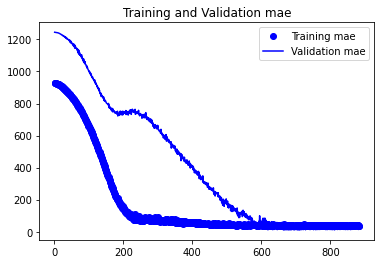

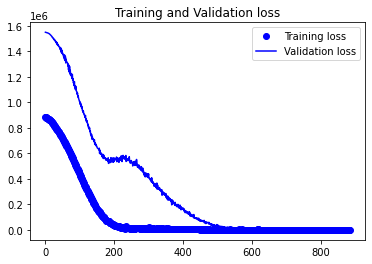

In [ ]:
for history in cache['histories']:
    plot_history(history)

In [ ]:
# model = cache['importances'][0]

# # model.get_booster().feature_names = col_names
# plot_features(model, (10, 14))

In [ ]:
# fear = pd.DataFrame()
# fear['Feature_name'] = model.get_booster().get_score(importance_type='weight').keys()
# fear['Feature_score'] = model.get_booster().get_score(importance_type='weight').values()
# fear.head()

In [ ]:
# selected = fear[fear['Feature_score'] >= 3]
# selected

In [ ]:
# from xgboost import plot_importance
# import matplotlib.pyplot as plt

# def plot_features(booster, figsize):    
#     fig, ax = plt.subplots(1, 1, figsize=figsize)
#     return plot_importance(booster=booster, ax=ax)

In [ ]:
# selected_arr = selected['Feature_name'].values
# for i in selected_arr:
#     print(i + ', ')